# SVM择时
利用SVM进行择时，目标是识别大趋势的到来

一、标注：<br>
- 判断未来5天涨幅是否大于2%，是则为1，不是则为0 <br>

二、特征：<br>
- 布林特征：价格在距离均线的z-score，识别噪声移动<br>
- macd特征：快慢均线之差，滞后判断趋势<br>
- 价格分位数特征：价格的位置，判断向上的空间<br>

三、模型：<br>
- svc默认rbf

四、结果：<br>
- 样本内68.5%
- 样本外如图

五、结论：<br>
- 样本太少，很玄学

In [51]:
import pandas as pd
# 读取300571.SZ的数据
raw_data = pd.read_csv('./stock_data.csv', index_col = 0)
raw_data = raw_data[raw_data.stock == '300571.SZ']
# 未来5天收盘价变化2%则为正样本，否则为负样本
raw_data['label'] = (raw_data.close.shift(-5) / raw_data.close - 1) >= 0.02
raw_data = raw_data.dropna()

## 特征选取

In [52]:
# 添加均线特征
raw_data['ma5'] = raw_data.close.rolling(5).mean()
raw_data['ma10'] = raw_data.close.rolling(10).mean()
raw_data['ma20'] = raw_data.close.rolling(20).mean()
# 添加乖离率特征
raw_data['bias5'] = (raw_data.close - raw_data.ma5) / raw_data.ma5
raw_data['bias10'] = (raw_data.close - raw_data.ma10) / raw_data.ma10
raw_data['bias20'] = (raw_data.close - raw_data.ma20) / raw_data.ma20
# 添加布林特征
raw_data['boll'] = (raw_data.close - raw_data.ma20) / (2 * raw_data.close.rolling(20).std())
# 添加MACD特征
raw_data['dif'] = raw_data.close.ewm(10).mean() - raw_data.close.ewm(26).mean()
raw_data['dea'] = raw_data.dif.ewm(5).mean()
raw_data['macd'] = 2 * (raw_data.dif - raw_data.dea)
# 添加价格的历史分位数
raw_data['price_rank'] = raw_data.close.rolling(21).apply(lambda x: x.rank()[-1] / 21)

In [53]:
# 提取布林特征，macd特征
data = raw_data[['boll', 'macd', 'price_rank', 'label']]
data = data.dropna()
# 标准化
data[['boll', 'macd', 'price_rank']] = (data[['boll', 'macd', 'price_rank']] - data[['boll', 'macd', 'price_rank']].mean()) / data[['boll', 'macd', 'price_rank']].std()
# 分割训练集与测试集
train = data[:int(len(data) * 0.8)]
test = data[int(len(data) * 0.8):]
# 生成训练集和测试集的特征和标签
train_x = train.drop('label', axis = 1)
train_y = train['label']
test_x = test.drop('label', axis = 1)
test_y = test['label']

In [54]:
# 导入SVM模型
from sklearn import svm
# 建立模型
model = svm.SVC()
# 训练模型
model.fit(train_x, train_y)
# 预测300571.SZ的涨跌
pred = model.predict(test_x)
# 评估
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y, pred))

0.6875


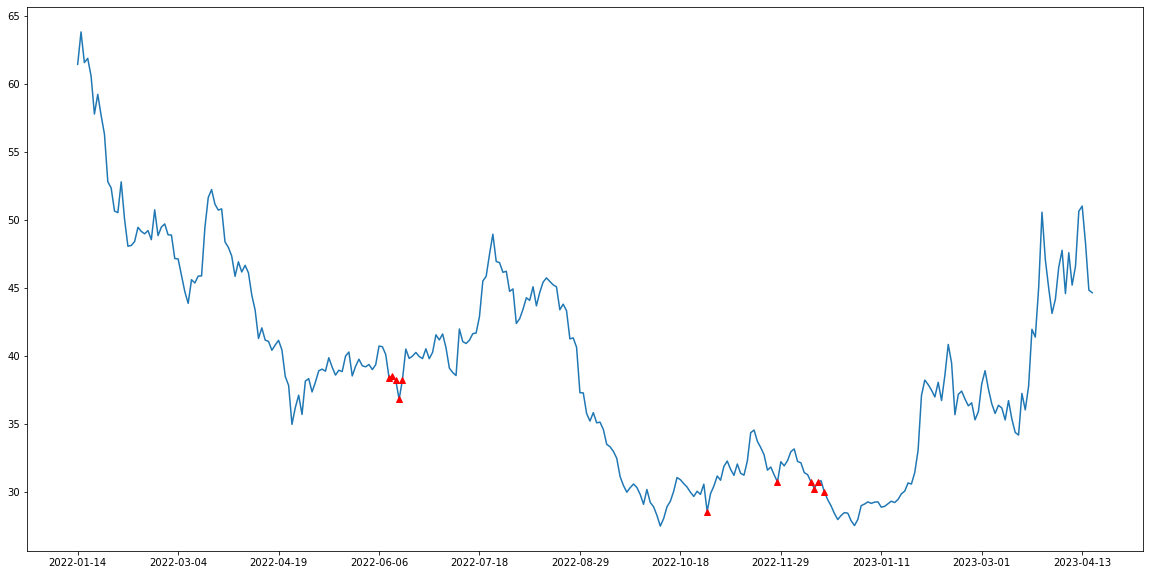

In [55]:
# 根据data中的数据，画出股票k线图
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20, 10))
plt.plot(test_x.index, raw_data['close'][test_x.index])
# 标记预测的买入点
plt.plot(test_x[pred == True].index, raw_data['close'][test_x[pred == True].index], 'r^')
my_x_ticks = np.arange(0, len(test_x.index), int(len(test_x.index) / 10))
plt.xticks(my_x_ticks)
plt.show()